In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
import numpy as np
from tqdm import tqdm
from copy import deepcopy
from tqdm import tqdm
from PIL import Image


In [42]:
class Picture_decomposition:
    '''
    Класс для работы с изображениями
    '''
    
    def __init__(self, path_name, pics_name, pic_size):
        self.path_name = path_name
        self.pics_name = pics_name
        self.pic_size = pic_size
        self.num_pics = None
        
    def get_pics_paths(self):
        path_list = []
        
        for path, subdirs, files in os.walk(self.path_name):
            for name in files:
                if name.endswith(self.pics_name):
                    path_list.append(os.path.join(path, name))
                    
        self.num_pics = len(path_list)
        
        return path_list
    
    def get_pics(self):
        path_list = self.get_pics_paths()
        pics_list = []
        
        for path in path_list:
            pic = Image.open(path)
            pic = pic.resize((self.pic_size, self.pic_size))
            pics_list.append(np.array(pic))
            pic.close()
            
        return np.array(pics_list)
        
    def get_random_pic(self, seed=1):
        path_list  = self.get_pics_paths()
        random_pic = random.Random(seed).choice(path_list)
        pic = Image.open(random_pic)
        pic = pic.resize((self.pic_size, self.pic_size))
        pic = np.array(pic)
        print(random_pic)
        plt.imshow(pic)
        
    def get_reshaped_pics(self):
        all_pics = self.get_pics()
        pics_reshaped = np.zeros((self.pic_size ** 2, len(all_pics), 3))
        
        for i, pic in enumerate(all_pics):
            for j in range(3):
                pics_reshaped[:, i, j] = pic[:,:,j].reshape(-1,1)[:,0]
        
        return pics_reshaped

    def get_mean_pic(self, show=False):
        all_pics_reshaped = self.get_reshaped_pics()
        mean_pic = np.mean(all_pics_reshaped, axis=1)
        
        if show:  
            plt.imshow(mean_pic.reshape((self.pic_size, self.pic_size, 3)) / 256)
            
        return mean_pic
    
    def get_centered_pics(self):
        pics_reshaped = self.get_reshaped_pics()
        mean_pic = self.get_mean_pic()
        
        for i in range(self.num_pics):
            pics_reshaped[:,i,:] -= mean_pic
        
        return pics_reshaped
        
    def compute_svd(self):
        centered_pics = self.get_centered_pics()
        ch_r = centered_pics[:,:,0]
        ch_g = centered_pics[:,:,1]
        ch_b = centered_pics[:,:,2]
        
        svd_r, svd_g, svd_b = np.linalg.svd(ch_r), np.linalg.svd(ch_g), np.linalg.svd(ch_b)
        
        return svd_r, svd_g, svd_b
    
    def get_subspace_pics(self, dim=1000):
        pics_reshaped = self.get_reshaped_pics()
        mean_pic = self.get_mean_pic()
        centered_pics = self.get_centered_pics()
        
        svd_r, svd_g, svd_b = self.compute_svd()
        
        result = np.zeros((dim, self.num_pics, 3))
        
        
        for i in tqdm(range(self.num_pics)):
            result[:,i,0] = svd_r[0][:,:dim].T @ (pics_reshaped[:,i,0] - mean_pic[:,0])
            result[:,i,1] = svd_g[0][:,:dim].T @ (pics_reshaped[:,i,1] - mean_pic[:,1])
            result[:,i,2] = svd_b[0][:,:dim].T @ (pics_reshaped[:,i,2] - mean_pic[:,2])
        
        return result
        
        

In [43]:
decomp = Picture_decomposition('CyberextruderUltimate/', '000001.jpg', 50)
a= decomp.get_subspace_pics(1000)

In [32]:
svd_r, svd_g, svd_b = decomp.compute_svd()

CyberextruderUltimate/000625/000001.jpg


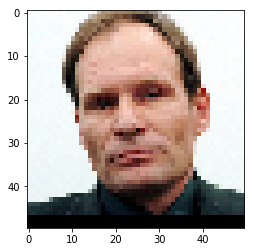

In [51]:
decomp.get_random_pic(7)

In [62]:
np.stack((p1,p2,p3), axis=2).shape

(50, 50, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


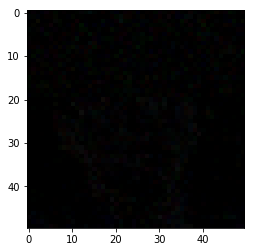

In [63]:
p1 = svd_r[0][0].reshape((50,50))
p2 = svd_g[0][0].reshape((50,50))
p3 = svd_b[0][0].reshape((50,50))

plt.imshow(np.stack((p1,p2,p3), axis=2))

In [109]:
path = 'CyberextruderUltimate/'
pics = []

for path, subdirs, files in os.walk(path):
    for name in files:
        if name.endswith('000001.jpg'):
            pics.append(os.path.join(path, name))

In [110]:
pics = sorted(pics)
pics[:3]

['CyberextruderUltimate/000001/000001.jpg',
 'CyberextruderUltimate/000002/000001.jpg',
 'CyberextruderUltimate/000003/000001.jpg']

In [111]:
PIC_SIZE = 100

img = Image.open(pics[0])
new_img = img.resize((PIC_SIZE,PIC_SIZE))
new_img = np.array(new_img)
new_img.shape

(100, 100, 3)

In [112]:
type(img)

PIL.JpegImagePlugin.JpegImageFile

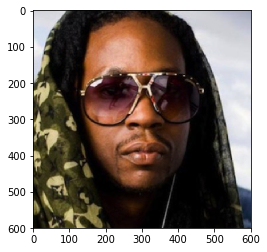

In [113]:
plt.imshow(img)

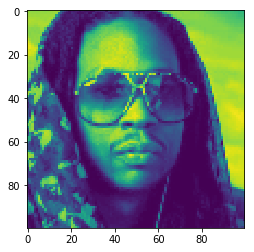

In [114]:
img_1 = new_img[:,:,0]
plt.imshow(img_1)

In [115]:
img_1.reshape(-1,1)[:,0].shape

(10000,)

In [116]:
imgs_reshaped = np.zeros((img_1.shape[0] ** 2, len(pics)))
imgs_reshaped.shape

(10000, 1000)

In [123]:
for i in tqdm(range(len(pics))):
    img = Image.open(pics[i])
    new_img = img.resize((PIC_SIZE,PIC_SIZE))
    new_img = np.array(new_img)[:,:,0]
    imgs_reshaped[:, i] = new_img.reshape(-1,1)[:,0]

100%|██████████| 1000/1000 [00:05<00:00, 175.95it/s]


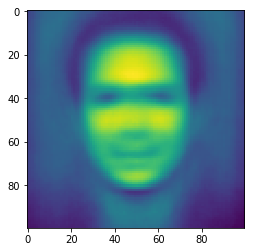

In [126]:
mean_img = np.mean(imgs_reshaped, axis=1)
plt.imshow(mean_img.reshape((PIC_SIZE, PIC_SIZE)) / 256)

In [127]:
A.shape

(10000, 3, 1000)

In [156]:
mean_img.shape

(10000, 3)

In [128]:
A = deepcopy(imgs_reshaped)

for i in tqdm(range(A.shape[1])):
    A[:,i] -= mean_img

100%|██████████| 1000/1000 [00:00<00:00, 9403.51it/s]


In [129]:
A.shape

(10000, 1000)

In [131]:
np.array_equal(A[:,0] + mean_img, imgs_reshaped[:,0])

True

In [132]:
%%time
U, E, V = np.linalg.svd(A)

CPU times: user 1min 52s, sys: 1.36 s, total: 1min 54s
Wall time: 19.2 s


In [41]:
U.shape, E.shape, V.shape

((10000, 10000), (1000,), (1000, 1000))

In [143]:
nonzero = len(E[E != 0])
nonzero

1000

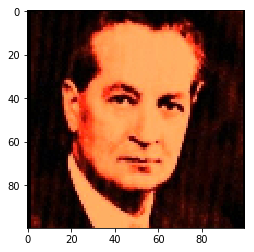

In [65]:
newpath = pics[10].replace('1.jpg', '3.jpg')
img = Image.open(newpath)
new_img = img.resize((PIC_SIZE,PIC_SIZE))
new_img = np.array(new_img)
plt.imshow(new_img)

In [66]:
new_img = new_img[:,:,0].reshape(-1,1)[:,0]
new_img.shape

(10000,)

In [67]:
sub_U = U[:,:nonzero]

x = sub_U.T @ (new_img - mean_img)
x.shape

(1000,)

In [68]:
min_val, min_id = np.inf, 100000

for i in tqdm(range(sub_U.shape[1])):
    cur_img = imgs_reshaped[:,0]
    x_i = sub_U.T @ (cur_img - mean_img)
    cur_eps = np.linalg.norm(x - x_i)
    if cur_eps < min_val:
        min_val, min_id = cur_eps, i

100%|██████████| 1000/1000 [02:42<00:00,  6.14it/s]


In [70]:
min_val

13817.822796446188

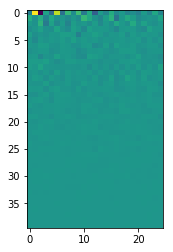

In [80]:
plt.imshow((sub_U.T @ (imgs_reshaped[:,0] - mean_img)).reshape(40,-1))

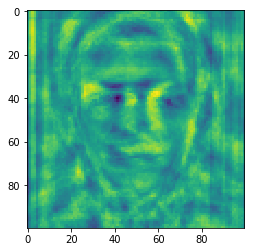

In [96]:
plt.imshow(U[:,100].reshape(-100,100))

In [75]:
imgs_reshaped[:,0].shape

(10000,)